# Comparing pRF predicted saliency to observed (fMRI betas) 



### Converting polar to cartesian coordinates

- Can then generate a 2D “image” which describes where each voxel “looks” at, in pixel space 
- Pointwise multiply/convolve the 2D image with the stimuli image(s) 
- This will tell how much *“Saliency drive”* each voxel is receiving for that stimuli image(s)


For example, for a `400 x 400` image:

- Unravel the 2D image for each voxel to get a `voxels x 1600`. Multiplay with an image of `1600 x 1` . This resuls in a vector of size `voxels x 1`. Now we can correlate this vector **(Predicted)** to the Betas **(Observed)** generated from the fMRI experiment.


Similar to this operation:

$\underset{v\times 1}{\mathrm{\hat{Y}}} =  \underset{voxels \times 1600}{K} \times \underset{1600\times 1}{\textbf{x}} $

In [1]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import matplotlib.pyplot as plt

/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import h5py
import os
import sys
import struct
import time
import pandas as pd
from scipy.io import loadmat

In [3]:
import src.DeepGaze.deepgaze_pytorch as deepgaze_pytorch

In [4]:
import nibabel as nib
import nilearn
from nilearn import image
from nilearn import plotting 
from nilearn.image import math_img

from pathlib import Path
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker

import pandas as pd
import seaborn as sns

%matplotlib inline

In [5]:
# Define Globals
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"

DEVICE = 'cpu'

Load the pRF data for the four subjects as pandas dataframes

In [6]:
prf_df_subj1 = pd.read_pickle(DATA_PATH+"/prf_df_subj1.pkl")
prf_df_subj2 = pd.read_pickle(DATA_PATH+"/prf_df_subj2.pkl")
prf_df_subj3 = pd.read_pickle(DATA_PATH+"/prf_df_subj3.pkl")
prf_df_subj4 = pd.read_pickle(DATA_PATH+"/prf_df_subj4.pkl")

In [7]:
prf_df_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_r2_data,v2_angle_data,v2_ecc_data,v2_sigma_data,v2_r2_data,v3_angle_data,v3_ecc_data,v3_sigma_data,v3_r2_data,v4_angle_data,v4_ecc_data,v4_sigma_data,v4_r2_data
0,179.639786,0.166852,0.003727,3.616053,33.354454,0.371874,0.076283,50.161469,140.120987,0.134440,0.038078,8.822984,274.955841,0.064470,0.038229,1.110393
1,15.860787,0.690822,0.110961,11.148829,28.464493,0.456244,0.062072,46.987682,165.033951,0.101685,0.036868,6.945145,70.285095,0.116665,0.221371,1.514173
2,163.424911,0.257483,0.022927,2.095020,31.106401,0.452306,0.090546,38.588326,218.715668,0.039451,0.038473,4.386640,66.330666,9.792632,0.619033,0.998151
3,155.249649,0.013332,0.003601,4.394990,14.747509,0.457834,0.034184,57.201149,124.930138,0.175418,0.048569,18.922060,294.979279,0.161613,0.039345,2.012455
4,157.556778,4.178980,0.003570,5.346769,29.082649,0.395024,0.072307,55.691982,96.409996,0.155090,0.055621,3.652459,25.160667,0.371230,0.003580,4.405111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,NaN,NaN,NaN,NaN,174.888580,0.050659,0.003312,22.607904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8292,NaN,NaN,NaN,NaN,176.268356,0.081027,0.137789,19.064182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8293,NaN,NaN,NaN,NaN,335.317413,2.464041,0.000000,-12.727165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8294,NaN,NaN,NaN,NaN,77.885071,0.711101,0.232145,1.501161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Convert polar to cartesian coordinates

We have the eccentricity (the radius) and the angle 

$x = r*cos(\theta), y = r*sin(\theta) $

In [8]:
# test for just v1 voxels for subject 1 


In [9]:
prf_v1_subj1 = prf_df_subj1[["v1_angle_data","v1_ecc_data","v1_sigma_data"]].dropna()

In [10]:
prf_v1_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data
0,179.639786,0.166852,0.003727
1,15.860787,0.690822,0.110961
2,163.424911,0.257483,0.022927
3,155.249649,0.013332,0.003601
4,157.556778,4.178980,0.003570
...,...,...,...
7882,247.916855,4.322491,0.016936
7883,2.510942,0.042029,0.003745
7884,105.356026,0.050834,0.213105
7885,15.703278,6.140235,0.000000


In [11]:
# Convert eccentricity (dva) to pixel space
prf_v1_subj1["v1_ecc_px"] = prf_v1_subj1["v1_ecc_data"]*714/8.4
prf_v1_subj1["v1_sigma_px"] =prf_v1_subj1["v1_sigma_data"]*714/8.4

In [12]:
prf_v1_subj1["x_coord"] = prf_v1_subj1["v1_ecc_px"]*np.cos(prf_v1_subj1["v1_angle_data"])
prf_v1_subj1["y_coord"] = prf_v1_subj1["v1_ecc_px"]*np.sin(prf_v1_subj1["v1_angle_data"])

In [13]:
prf_v1_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
0,179.639786,0.166852,0.003727,14.182429,0.316797,-11.947813,-7.641403
1,15.860787,0.690822,0.110961,58.719901,9.431697,-58.035526,-8.938927
2,163.424911,0.257483,0.022927,21.886015,1.948820,21.843837,1.358106
3,155.249649,0.013332,0.003601,1.133192,0.306052,-0.290432,-1.095342
4,157.556778,4.178980,0.003570,355.213289,0.303448,315.539360,163.129988
...,...,...,...,...,...,...,...
7882,247.916855,4.322491,0.016936,367.411749,1.439564,-354.202014,97.633637
7883,2.510942,0.042029,0.003745,3.572496,0.318334,-2.885306,2.106595
7884,105.356026,0.050834,0.213105,4.320889,18.113886,0.485813,-4.293492
7885,15.703278,6.140235,0.000000,521.919971,0.000000,-521.914241,2.445541


In [14]:
from scipy import stats


In [109]:
# COCO image dimnensions
X_SIZE = 400 
Y_SIZE = 400 

# Perform for voxel 0
voxel_idx = 19
sigma = prf_v1_subj1["v1_sigma_px"][voxel_idx]
mu = [prf_v1_subj1["x_coord"][voxel_idx],prf_v1_subj1["y_coord"][voxel_idx]]

print(sigma)
print(mu)

0.0
[-11.344913922663725, -34.991444920172974]


In [110]:
ys, xs = np.mgrid[Y_SIZE:0:-1, 0:X_SIZE]
ys -= Y_SIZE // 2
xs -= X_SIZE // 2


x1d = xs.ravel()
y1d = ys.ravel()

In [114]:
prf_v1_subj1[5:25]

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
5,173.044830,0.078608,0.111416,6.681655,9.470335,-6.461811,-1.699859
6,169.128433,0.127111,0.043819,10.804458,3.724654,9.389333,-5.345721
7,166.787109,0.124297,0.026400,10.565246,2.244011,-10.145871,-2.947157
8,152.706879,4.341500,0.032497,369.027524,2.762224,-122.938910,347.947320
9,186.975464,0.255245,0.058185,21.695797,4.945702,1.099527,-21.667918
10,144.361740,0.081615,0.092963,6.937300,7.901893,6.857816,-1.047136
11,137.951370,0.103035,0.119344,8.757980,10.144274,8.420028,-2.409428
12,151.396179,0.347906,0.035246,29.572022,2.995938,24.411320,16.691074
13,175.472824,0.003608,0.005732,0.306640,0.487204,0.275258,-0.135132
14,268.954529,1.999031,0.874783,169.917620,74.356523,58.002040,-159.711493


In [117]:
(prf_df_subj1 == 0).sum()

v1_angle_data     0
v1_ecc_data       0
v1_sigma_data    89
v1_r2_data       35
v2_angle_data     0
v2_ecc_data       0
v2_sigma_data    87
v2_r2_data       51
v3_angle_data     0
v3_ecc_data       0
v3_sigma_data    33
v3_r2_data       33
v4_angle_data     0
v4_ecc_data       0
v4_sigma_data    37
v4_r2_data       15
dtype: int64

In [112]:

if sigma !=0:
    mvn = stats.multivariate_normal(mu, sigma)
elif sigma == 0:
    

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [88]:
vals1d = mvn.pdf(np.vstack((y1d, x1d)).T)
vals = vals1d.reshape(X_SIZE, Y_SIZE)
print(vals1d.shape, vals1d.dtype)

(160000,) float64


In [89]:
vals1d

array([0., 0., 0., ..., 0., 0., 0.])

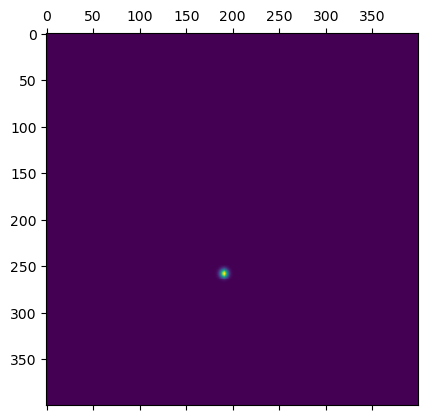

In [90]:
plt.matshow(vals)

In [59]:
np.sum(vals1d)

1.0000000000000002

In [21]:
# Perform for all voxels and create a matrix K (voxels x 1600) 

In [107]:
def generate_voxel_maps(dataframe):
    
    voxels_num = dataframe.shape[0]
    voxel_map = np.ones([160000,])
    
    for voxel_idx in range(0,voxels_num):
        
        sigma = dataframe["v1_sigma_px"][voxel_idx]
        mu = [dataframe["x_coord"][voxel_idx],dataframe["y_coord"][voxel_idx]]
        print(f"Voxel {voxel_idx}, sigma = {sigma}, mu = {mu}")
        # print(sigma,mu)

        ys, xs = np.mgrid[Y_SIZE:0:-1, 0:X_SIZE]
        ys -= Y_SIZE // 2
        xs -= X_SIZE // 2


        x1d = xs.ravel()
        y1d = ys.ravel()

        mvn = stats.multivariate_normal(mu, sigma)
        
#         if sigma !=0:
#             mvn = stats.multivariate_normal(mu, sigma)
#         elif sigma == 0:
#             # Create a matrix with where everything is 0 except at the pixels of x,y , where it's 1
            # so that it sums to 1
        
        vals1d = mvn.pdf(np.vstack((y1d, x1d)).T) # 160000 x 1 
        
        # print(vals1d)
        
        
        voxel_map = np.vstack((voxel_map,vals1d))
        # vals = vals1d.reshape(X_SIZE, Y_SIZE)
        # plt.matshow(vals)
        
    return voxel_map

In [108]:
voxel_map = generate_voxel_maps(prf_v1_subj1)

Voxel 0, sigma = 0.31679715495556593, mu = [-11.947813348689765, -7.641402907955074]
Voxel 1, sigma = 9.431696832180023, mu = [-58.03552648947625, -8.938927257221515]
Voxel 2, sigma = 1.948820110410452, mu = [21.843836586491207, 1.3581064260742255]
Voxel 3, sigma = 0.30605212319642305, mu = [-0.29043153583167464, -1.0953417635803064]
Voxel 4, sigma = 0.30344801605679095, mu = [315.5393604990186, 163.12998756633556]
Voxel 5, sigma = 9.470335058867931, mu = [-6.461810500531207, -1.6998591837768289]
Voxel 6, sigma = 3.724654186517, mu = [9.389333365199677, -5.345720945845164]
Voxel 7, sigma = 2.2440113872289658, mu = [-10.145870780953764, -2.9471572082665407]
Voxel 8, sigma = 2.7622244134545326, mu = [-122.93891044612168, 347.9473203859914]
Voxel 9, sigma = 4.945701882243156, mu = [1.0995269333350561, -21.667917627122623]
Voxel 10, sigma = 7.901893220841885, mu = [6.857816260160444, -1.0471356998213486]
Voxel 11, sigma = 10.14427449554205, mu = [8.420028205369743, -2.4094282001315923]
Vox

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [105]:
voxel_map

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

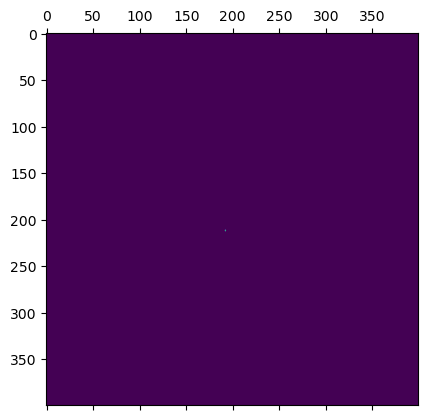

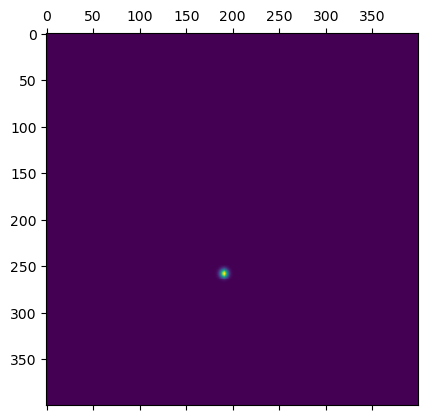

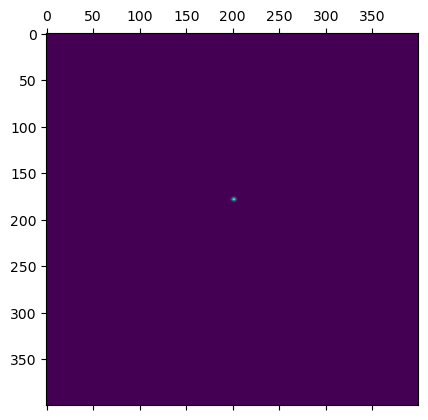

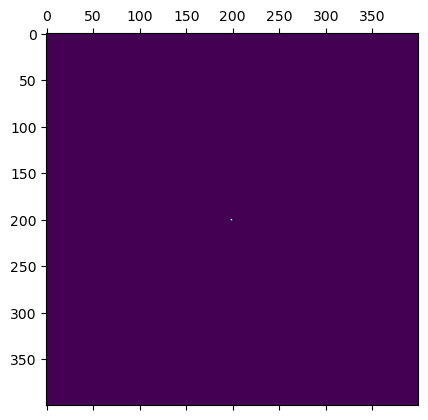

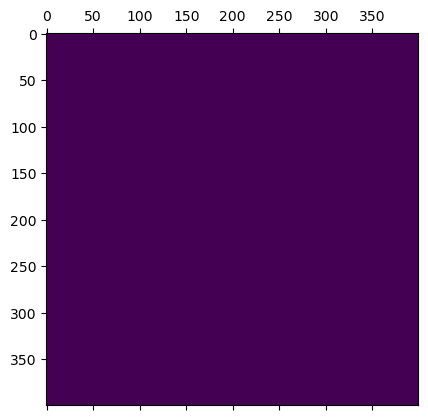

In [106]:
for i in range(1,voxel_map.shape[0]):
    vals = voxel_map[i].reshape(X_SIZE, Y_SIZE)
    plt.matshow(vals)

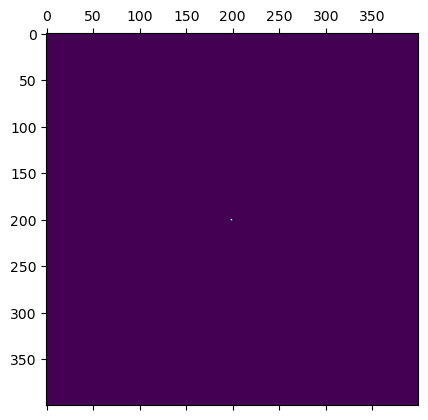